# scDEF on 3k PBMCs
scDEF is a statistical model that learns signatures of gene expression at multiple levels of resolution. The model enables dimensionality reduction, clustering, and de novo signature identification from scRNA-seq data. scDEF can be run in a fully unsupervised manner, or be guided by known gene sets, which we denote informed scDEF (iscDEF). 

Here we apply scDEF in its unsupervised and informed versions to the 3k PBMCs data set from 10x Genomics used in the `scanpy` [tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html), using annotations obtained from [`Seurat`](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html).

### Create a ground truth
We will use known markers and the true hierarchical structure for the cell types in this data set to evaluate the performance of scDEF.

In [1]:
markers = {'Memory CD4 T': ['IL7R', 'CD3D', 'CD3E'], 'Naive CD4 T': ['IL7R', 'CCR7', 'CD3D', 'CD3E'],  'CD8 T': ['CD8B', 'CCL5', 'CD2', 'CD3D', 'CD3E'], 
           'NK': ['GNLY', 'NKG7'], 
           'B': ['MS4A1', 'CD79A'], 
           'CD14+ Mono': ['CD14', 'LYZ'],  'FCGR3A+ Mono': ['FCGR3A', 'MS4A7'],  'DC': ['FCER1A', 'CST3', 'CD74'], 
           'Platelet': ['PPBP', 'PF4']}

true_hierarchy = {'T': ['CD8 T', 'Memory CD4 T', 'Naive CD4 T'], 
                  'Mono': ['FCGR3A+ Mono', 'CD14+ Mono'], 
                  'Platelet': [], 
                  'B': [],
                  'CD8 T': [],
                  'Memory CD4 T': [],
                  'Naive CD4 T': [],
                  'NK': [],
                  'FCGR3A+ Mono': [],
                  'CD14+ Mono': [],
                  'DC': []}

### Load packages and data

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import scdef

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We apply the usual basic filtering for cells and genes with very low numbers of reads. While scDEF does not require further prior gene selection, it is useful to remove genes which are known to be noisy in scRNA-seq data sets, such as MALAT1. We also apply liberal highly variable gene filtering to make sure we include all possible marker genes while reducing the runtime required to fit the model.

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


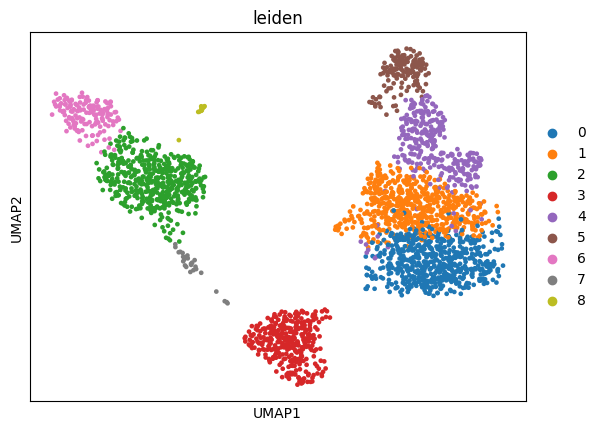

In [3]:
adata = sc.read_10x_mtx(
    'pbmcs_data/pbmcs3k/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata.obs.index = adata.obs.index.str.replace('-1', '')

# Remove MALAT1
adata = adata[:,adata.var_names!='MALAT1']
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

adata.layers['counts'] = adata.X.toarray() # Keep the counts, for scDEF
adata.raw = adata

# Keep only HVGs
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='counts', n_top_genes=4000) # Not required, but makes scDEF faster
adata = adata[:, adata.var.highly_variable]

# Process and visualize the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

Let's add the cell type annotations obtained from Seurat on this data set and add use it to create coarser cell type annotations. This will be useful to evaluate the scDEF hierarchy.

In [4]:
annotations = pd.read_csv('pbmcs_data/pbmcs3k/annotations.csv', index_col=0)

map_coarse = {}
for c in annotations['seurat_annotations'].astype("category").cat.categories:
    if c.endswith(' T'):
        map_coarse[c] = 'T'
    elif c.endswith('Mono'):
        map_coarse[c] = 'Mono'
    else:
        map_coarse[c] = c
        
adata.obs['Cell types'] = annotations['seurat_annotations']

adata.obs['Coarse cell types'] = (
    adata.obs['Cell types']
    .map(map_coarse)
    .astype('category')
)

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


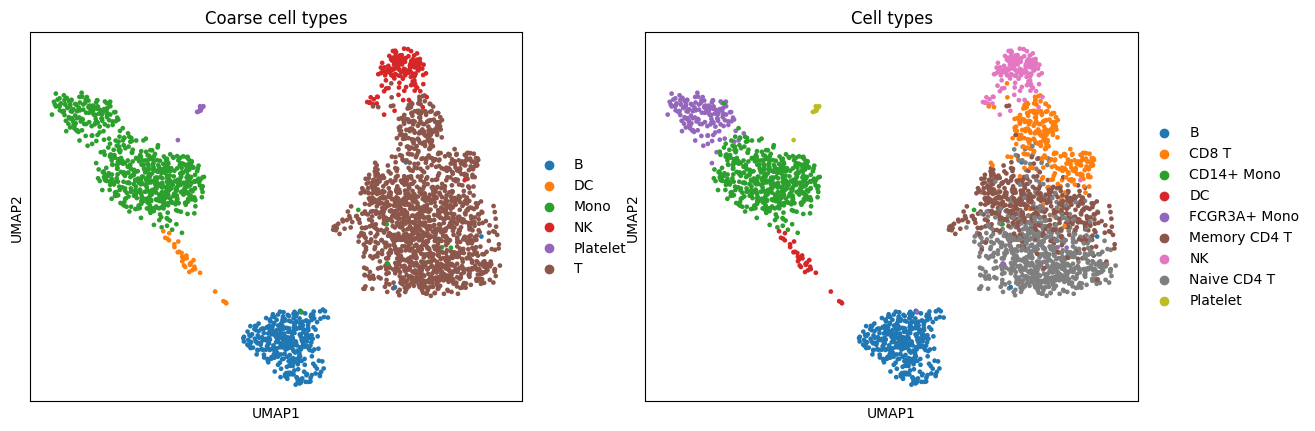

In [5]:
# Look at the data
sc.pl.umap(adata, color=['Coarse cell types', 'Cell types'])

## scDEF
The basic scDEF learns a multilayer representation of scRNA-seq data without any prior information.

### Learn scDEF

We start by creating an scDEF object from the AnnData object containing the gene expression counts. scDEF requires raw counts, so we tell it to get them in the `counts` layer that we created in the pre-processing step. The model is initialized with 5 layers of sizes 100, 60, 30, 10, and 1. Due to the sparsity priors in the factor weights, most of these will be removed in the learned model, which will yield a compact representation of the hierarchical structure of the data.

In [6]:
scd = scdef.scDEF(adata, counts_layer='counts')
print(scd) # inspect the scDEF object, which contains a copy of the input AnnData

scDEF object with 5 layers
	Layer names: factor, hfactor, hhfactor, hhhfactor, hhhhfactor
	Layer sizes: 100, 60, 30, 10, 1
	Layer shape parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer rate parameters: 0.3, 2.623, 8.743333333333334, 15.738000000000001, 31.476000000000003
	Layer factor shape parameters: 1.0, 0.3, 0.3, 0.3, 1.0
	Layer factor rate parameters: 100.0, 0.3, 0.3, 0.3, 1.0
	Using BRD with prior parameter: 1000.0
	Number of batches: 1
Contains AnnData object with n_obs × n_vars = 2623 × 4000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell types', 'Coarse cell types'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Coarse cell types_colors', 'Cell types_colors'
    obsm: 'X_pca', 'X_um

Fit the model to data. By default, this will run two rounds of optimization with decreasing learning rates.

In [7]:
scd.learn() # learn the hierarchical gene signatures

100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s, Loss=2.97e+6]


scDEF updated the internal AnnData object with:
* Assignment of cells to factors at each layer: `scd.adata.obs`
* Weight of each cell to each factor at each layer: `scd.adata.obs`
* Cells by factors matrices at each layer: `scd.adata.obsm`
* Gene signatures for each factor at each layer: `scd.adata.uns`

Additionally, it created a graph in Graphviz format containing the learned hierarchy: `scd.graph`.

Let's inspect the updated object to confirm the presence of the new annotations in the internal `AnnData` object.

In [8]:
print(scd) # inspect the updated scDEF object

scDEF object with 5 layers
	Layer names: factor, hfactor, hhfactor, hhhfactor, hhhhfactor
	Layer sizes: 11, 6, 3, 1, 1
	Layer shape parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer rate parameters: 0.3, 2.623, 8.743333333333334, 15.738000000000001, 31.476000000000003
	Layer factor shape parameters: 1.0, 0.3, 0.3, 0.3, 1.0
	Layer factor rate parameters: 100.0, 0.3, 0.3, 0.3, 1.0
	Using BRD with prior parameter: 1000.0
	Number of batches: 1
Contains AnnData object with n_obs × n_vars = 2623 × 4000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell types', 'Coarse cell types', 'cell_scale', 'factor', '0_score', '1_score', '2_score', '3_score', '4_score', '5_score', '6_score', '7_score', '8_score', '9_score', '10_score', 'hfactor', 'h0_score', 'h1_score', 'h2_score', 'h3_score', 'h4_score', 'h5_score', 'hhfactor', 'hh0_score', 'hh1_score', 'hh2_score', 'hhhfactor', 'hhh0_score', 'hhhhfactor', 'hhhh0_score'
    var: 'gene_ids', 'n_cells', 

Check that the ELBO converged.

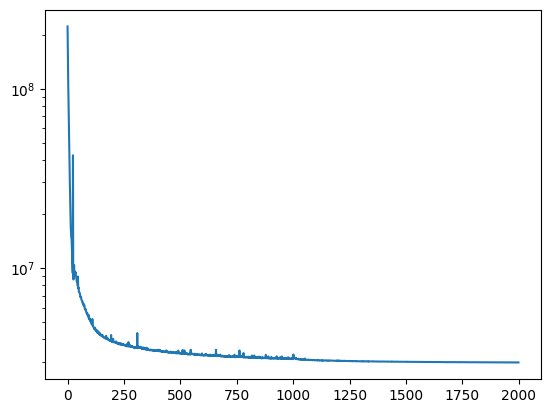

In [9]:
plt.plot(np.concatenate(scd.elbos)[:])
plt.yscale('log')
plt.show()

### Inspect size factors
scDEF is able to learn gene signatures that are not confounded by library sizes and gene detection rates because it explicitely models cell and gene scale factors. To make sure these are not captured in the factors, it's a good idea to confirm that the model successfully captured these biases.

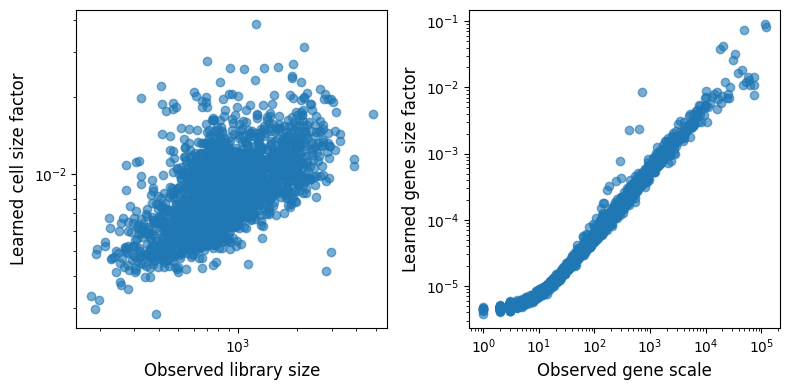

In [10]:
scd.plot_scales()

### Inspect automatic model pruning
By default, scDEF learns 100 factors at the highest resolution level (i.e., the lowest layer, layer 0). It also learns relevance estimates for each one, which leads to automatic model pruning. By default, after inference scDEF additionally only keeps the factors to which at least 10 cells attach and that have a relevance higher than 5 times the IQR of all the BRDs. This can be changed with `scd.filter_factors`. 

The `scd.plot_brd` utility function shows the relevancies learned for the factors.

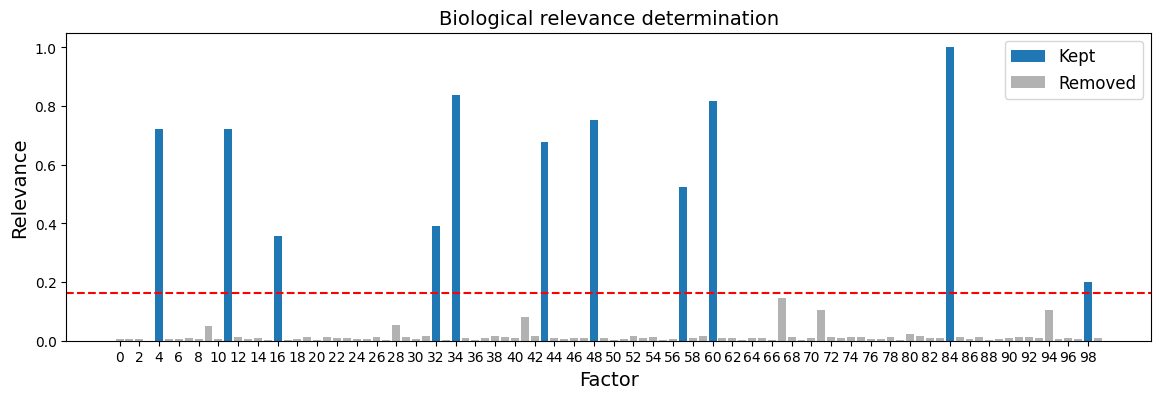

In [11]:
scd.plot_brd(iqr_mult=50, figsize=(14,4))

The scDEF model is constructed in such a way that the kept factors are the sparser ones. The underlying assumption is that sparse factors (where only a few genes are active) reflect biological signal, and dense factors (where many genes are active) capture technical variation. We can assess the sparsity of all the factors through their Gini index.

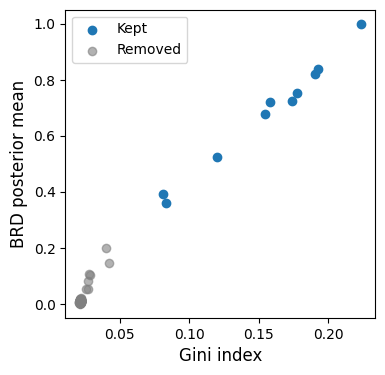

In [12]:
scd.filter_factors(iqr_mult=50)
scd.plot_gini_brd()

### Downstream analyses
scDEF produces a hierarchy of factors containing gene signatures for cell states at multiple levels of resolution. We can visualize the hierarchy as a graph, inspect its gene signatures, assign cells to factors, project each layer to 2D, and check associations between the factors and user-provided cell annotations.

#### Visualize scDEF graph
We can visualize the learned scDEF using `scd.make_graph`, which uses Graphviz to plot the scDEF graph.

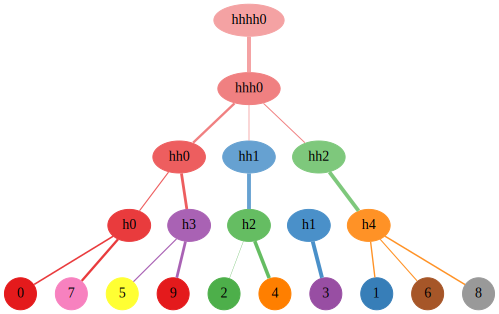

In [13]:
scd.make_graph(filled='factor', show_signatures=False) # simple graph with colorful nodes
scd.graph # Graphviz object

The scDEF hierarchy contains redudant connections, i.e., factors which capture the same cell population across different layers. We can merge these to obtain a more compact representation of the hierarchy.

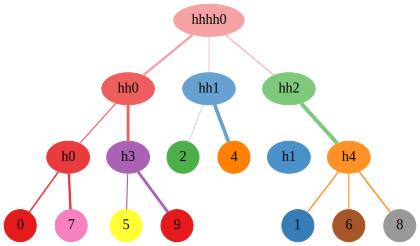

In [14]:
hierarchy_scdef = scd.get_hierarchy()

scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, filled='factor')
scd.graph

And we can directly visualize the gene expression signatures associated with each factor in the hierarchy. We also set `n_cells=True` to show the number of cells that attach to each factor.

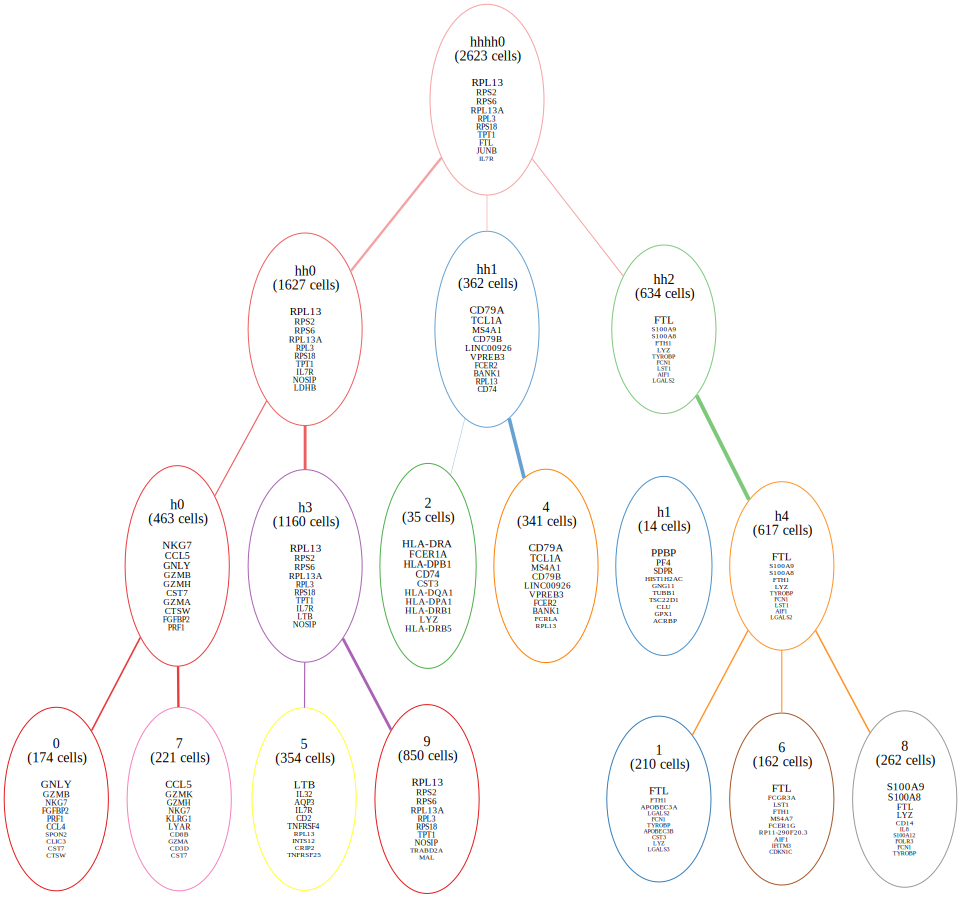

In [15]:
scd.make_graph(hierarchy=hierarchy_scdef, n_cells_label=True)
scd.graph

We can also scale the node sizes by the fraction of cells that attach to the corresponding factor by setting `n_cells=True`. 

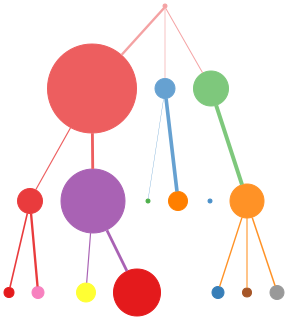

In [16]:
scd.make_graph(hierarchy=hierarchy_scdef, 
               n_cells=True, # scale nodes by fraction of attached cells
               filled='factor', # color the nodes
               show_label=False, # remove labels to make the visualization neater
            ) 
scd.graph

#### Visualize cell to factor weights
Each cell assigns a weight to a factor. The factors at the lowest level tend to capture different cell populations at high resolution which are aggregated in the upper levels. We can easily visualize the weights (or scores) of the factors at the lowest level in the original UMAP.

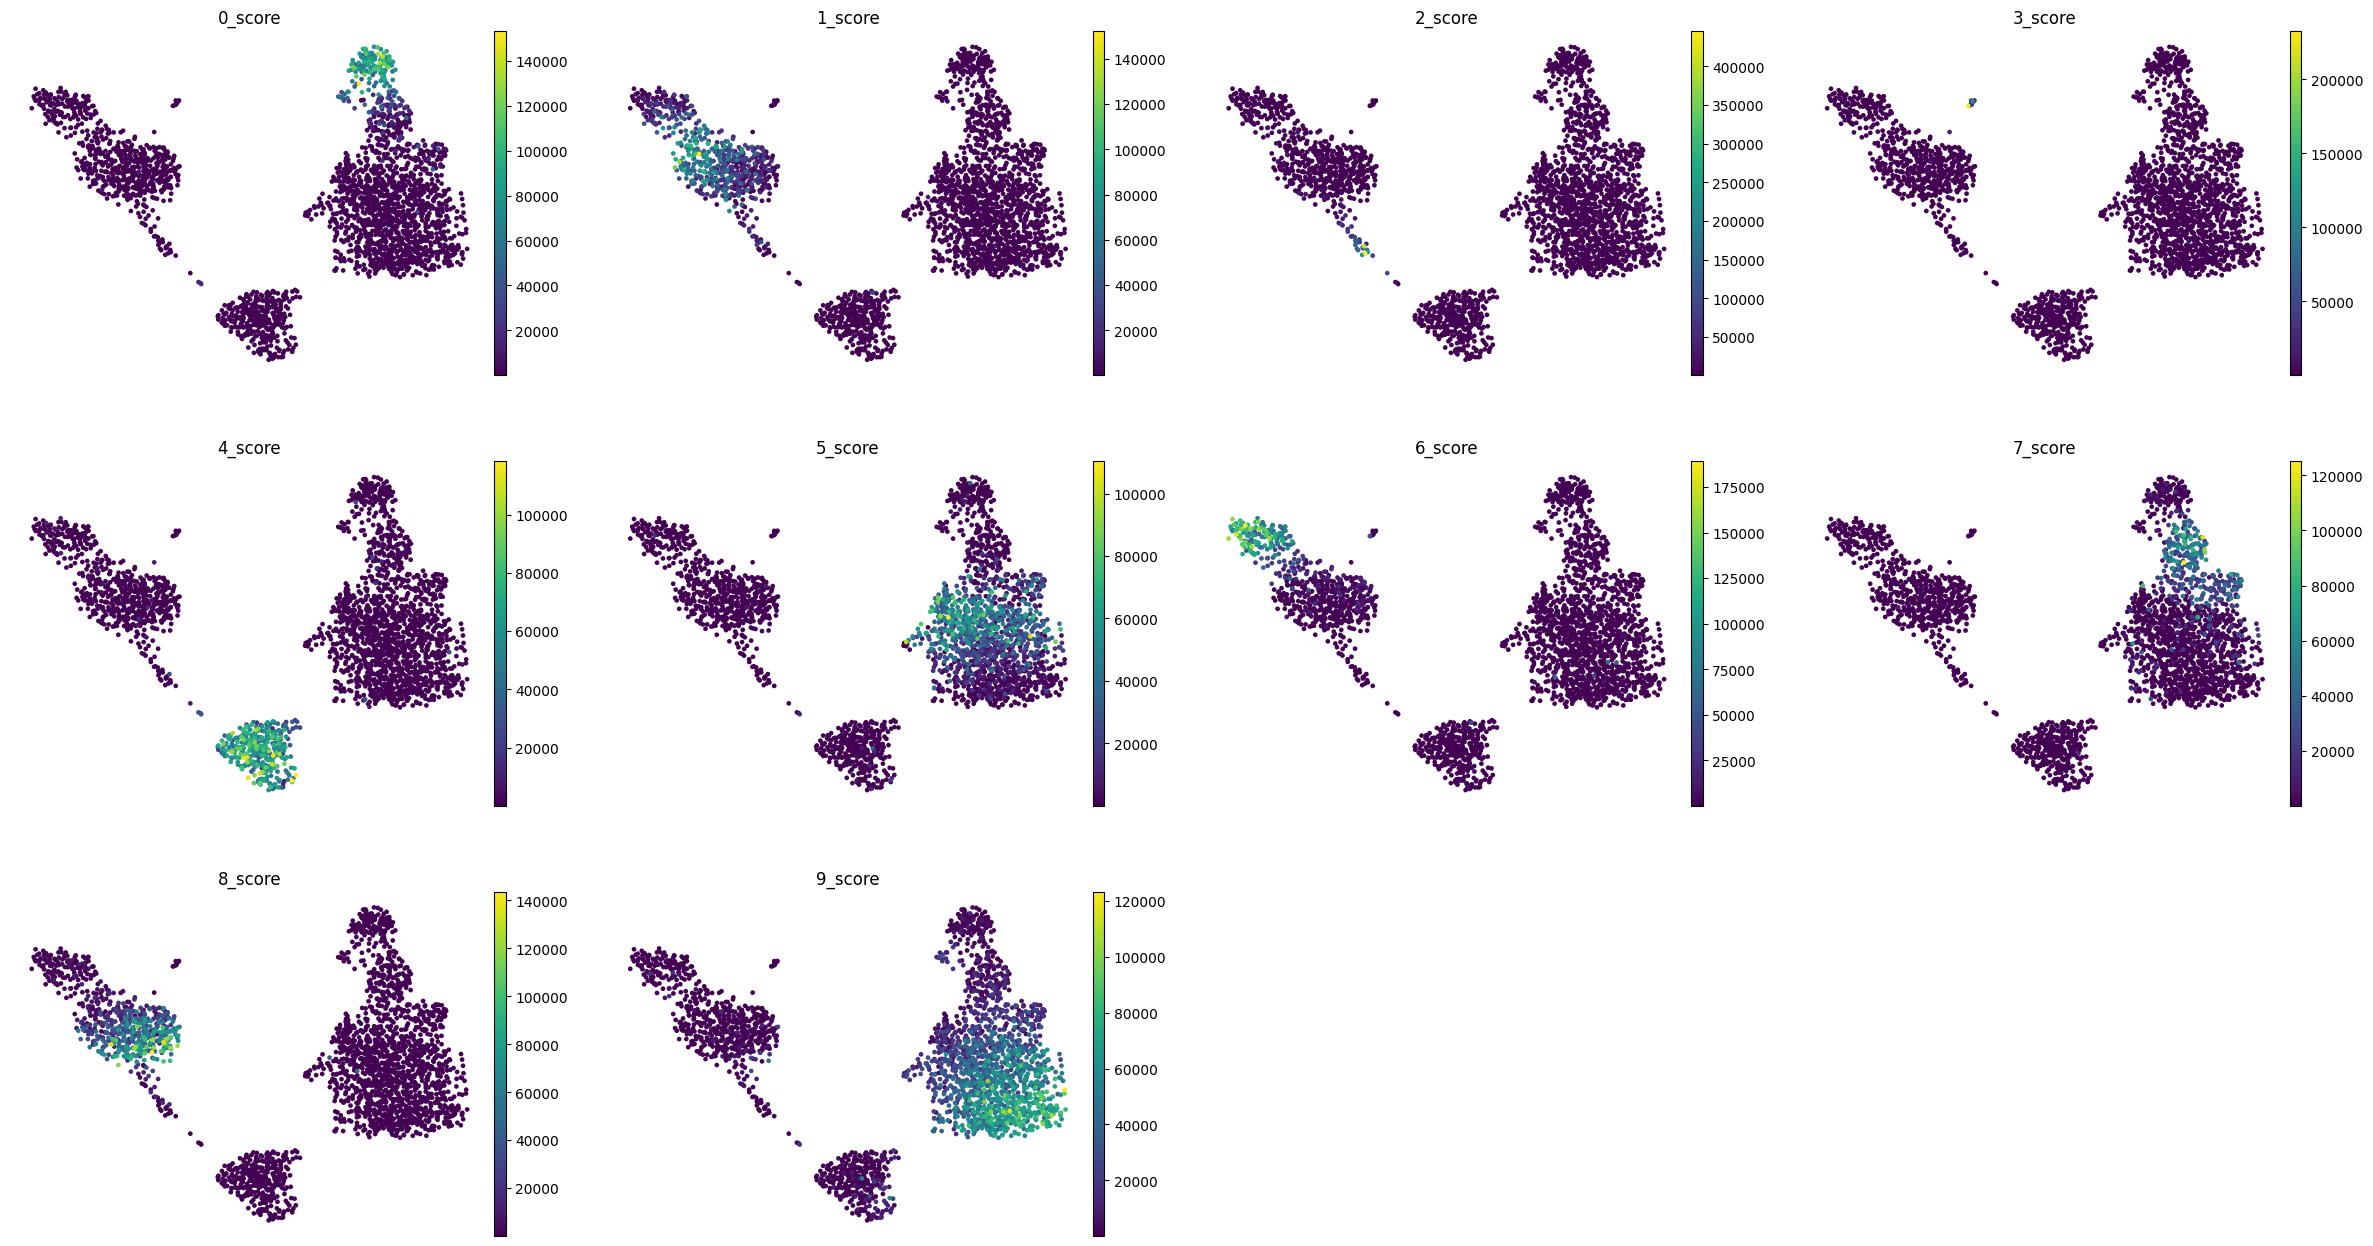

In [17]:
sc.pl.umap(scd.adata, color=[f'{i}_score' for i in range(len(scd.factor_lists[0]))], frameon=False)

#### Visualize cell to factor assignments
Based on the cell-to-factor weights, scDEF assigns each cell to each factor at each level of resolution. We can visualize these assignments in the original UMAP.

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


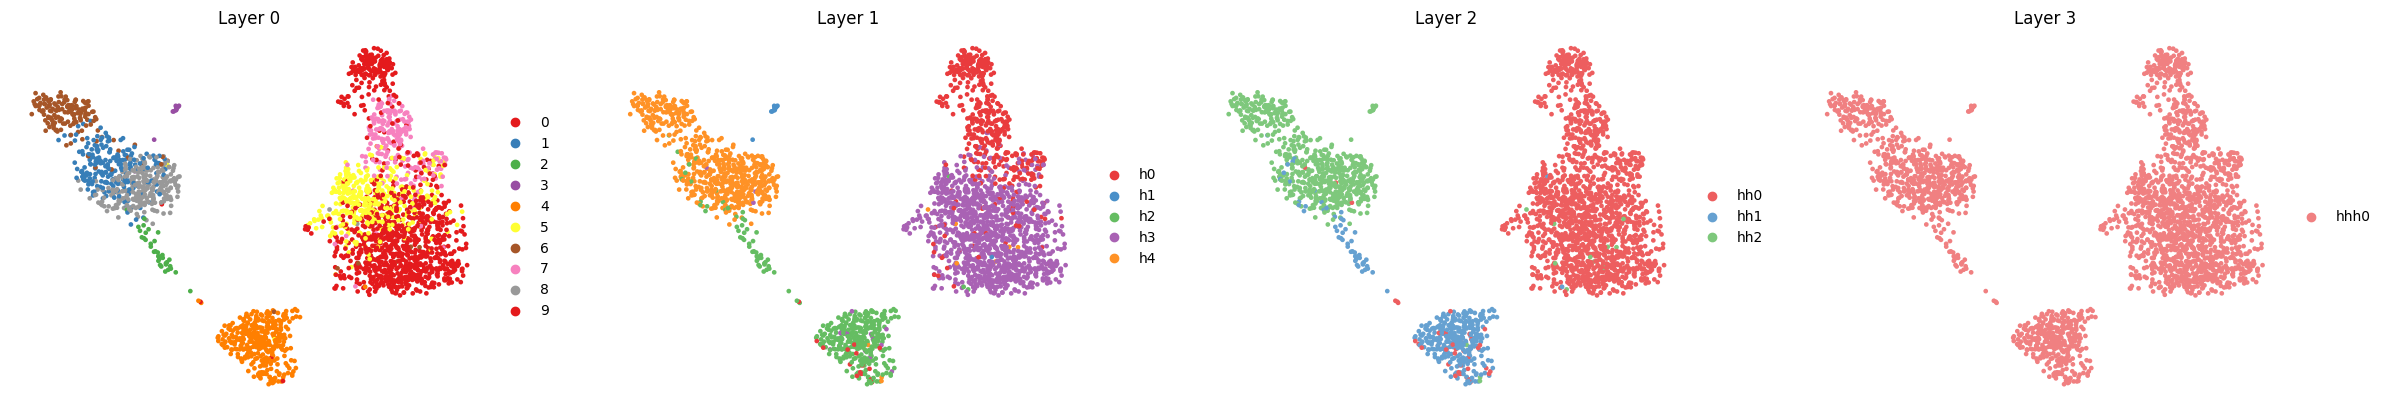

In [18]:
sc.pl.umap(scd.adata, color=['factor', 'hfactor', 'hhfactor', 'hhhfactor'], 
           title=['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3'], frameon=False)

#### UMAP visualization of scDEF layers
We can use the factors at each layer of the learned scDEF as embeddings of the cells in lower-dimensional spaces, and visualize them in 2D using, for example, a UMAP.

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/pytho

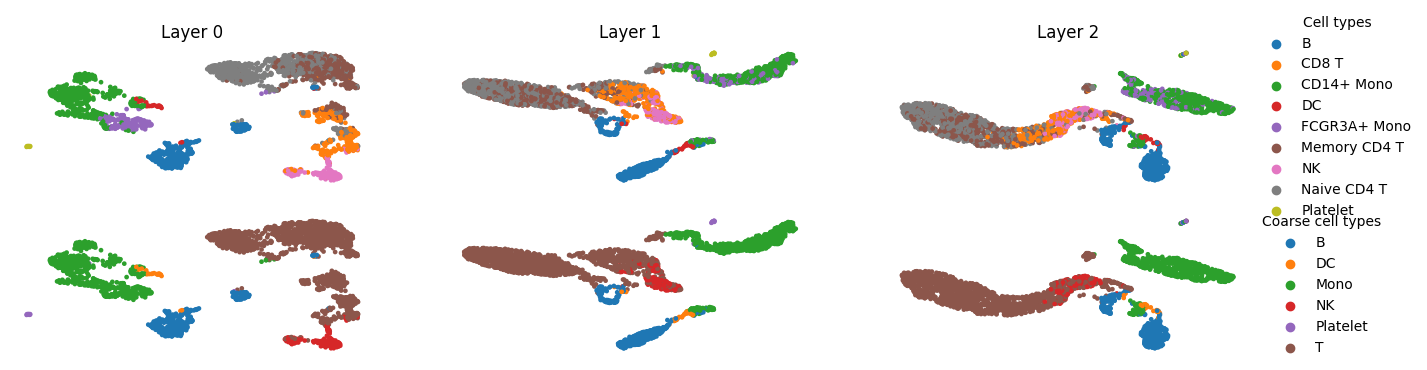

In [19]:
scd.plot_umaps(color=['Cell types', 'Coarse cell types'])

#### Association of factors with annotations
By attaching cells to the factors that they assign most of their weight to, and comparing those assignments with the ground truth annotations, we can check which factors associate most strongly with which annotations.

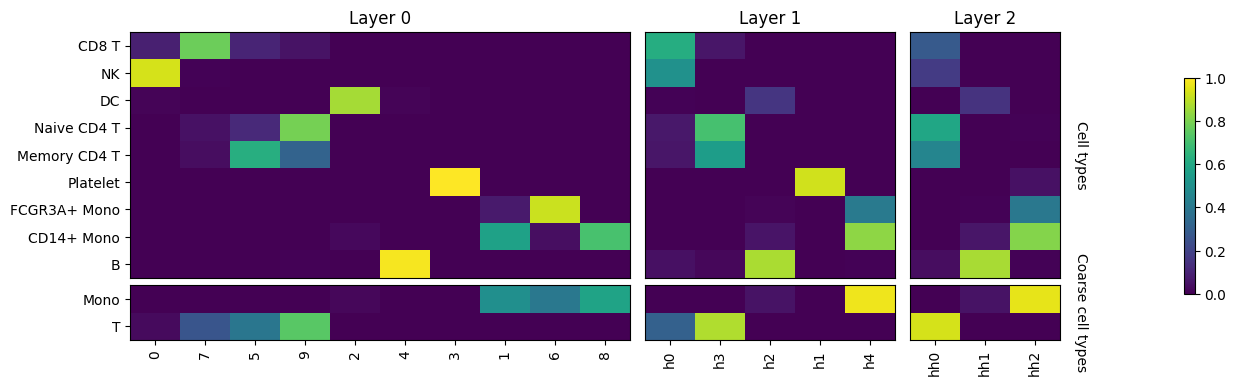

In [20]:
obs_keys = ['Cell types', 'Coarse cell types']
scd.plot_obs_scores(obs_keys, hierarchy=true_hierarchy, figsize=(16,4))

Another way to check the association of factors with the provided annotations is to color each node in the graph with the fraction of cells in it that belong to each given cell type. To do this, we set `wedged='celltypes'` in `scd.make_graph`. We normalize the fractions by the total size of each cell type.

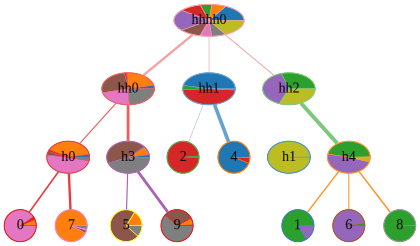

In [21]:
scd.make_graph(hierarchy=hierarchy_scdef, show_signatures=False, wedged='Cell types')
scd.graph

If we take a step further and label the factors by the annotations that they most strongly associate with, we can further validate the hierarchy.

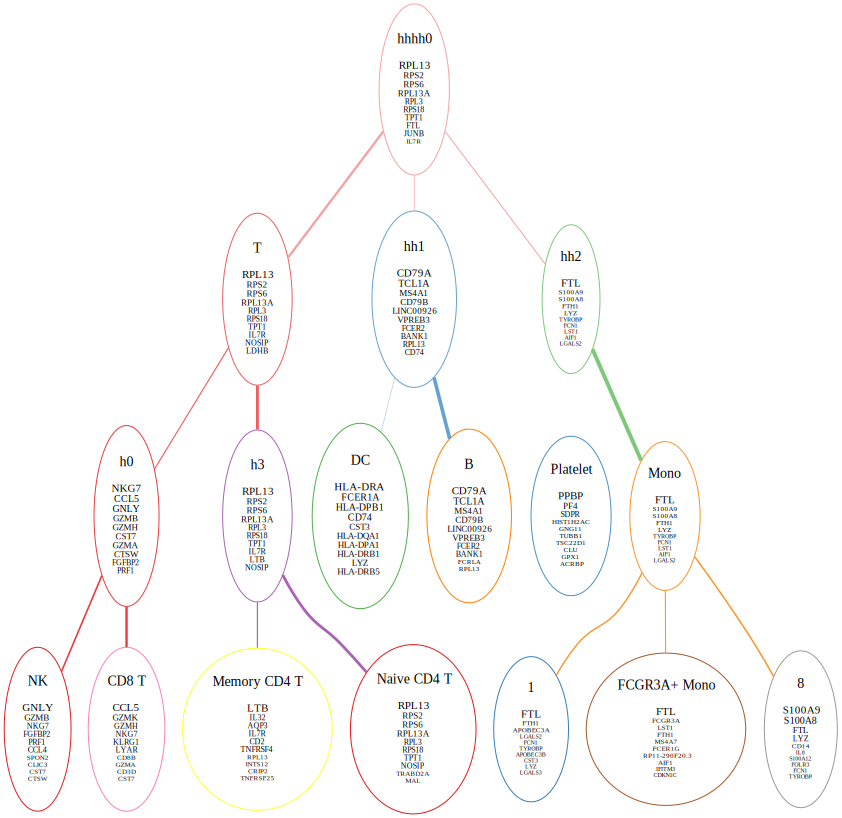

In [22]:
# Assign factors in simplified hierarchy to annotations
assignments, matches = scd.assign_obs_to_factors(obs_keys,
                            factor_names=scdef.utils.hierarchy_utils.get_nodes_from_hierarchy(hierarchy_scdef))

# Show graph with new labels 
scd.make_graph(hierarchy=hierarchy_scdef, factor_annotations=matches)
scd.graph

With these assignments, we can select a particular lineage to plot. Additionally, here we also show the gene signature confidences by setting `show_confidences=True`.

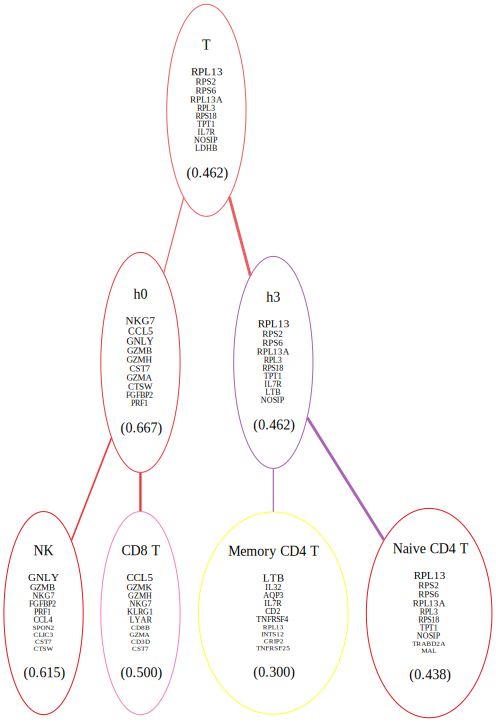

In [23]:
scd.make_graph(hierarchy=hierarchy_scdef, top_factor=assignments['T'], factor_annotations=matches, 
               show_confidences=True, mc_samples=10)
scd.graph

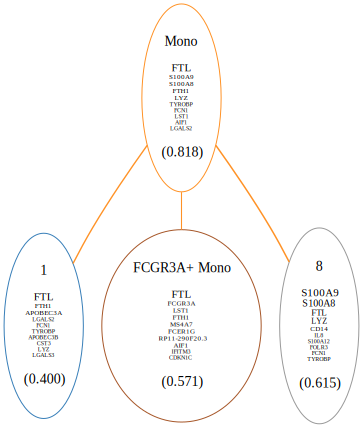

In [24]:
scd.make_graph(hierarchy=hierarchy_scdef, top_factor=assignments['Mono'], factor_annotations=matches, 
               show_confidences=True, mc_samples=10)
scd.graph

#### Gene signatures
scDEF provides gene signatures for each factor in each layer in `scd.adata.uns`, which allows for interaction with `scanpy`'s plotting utilities.

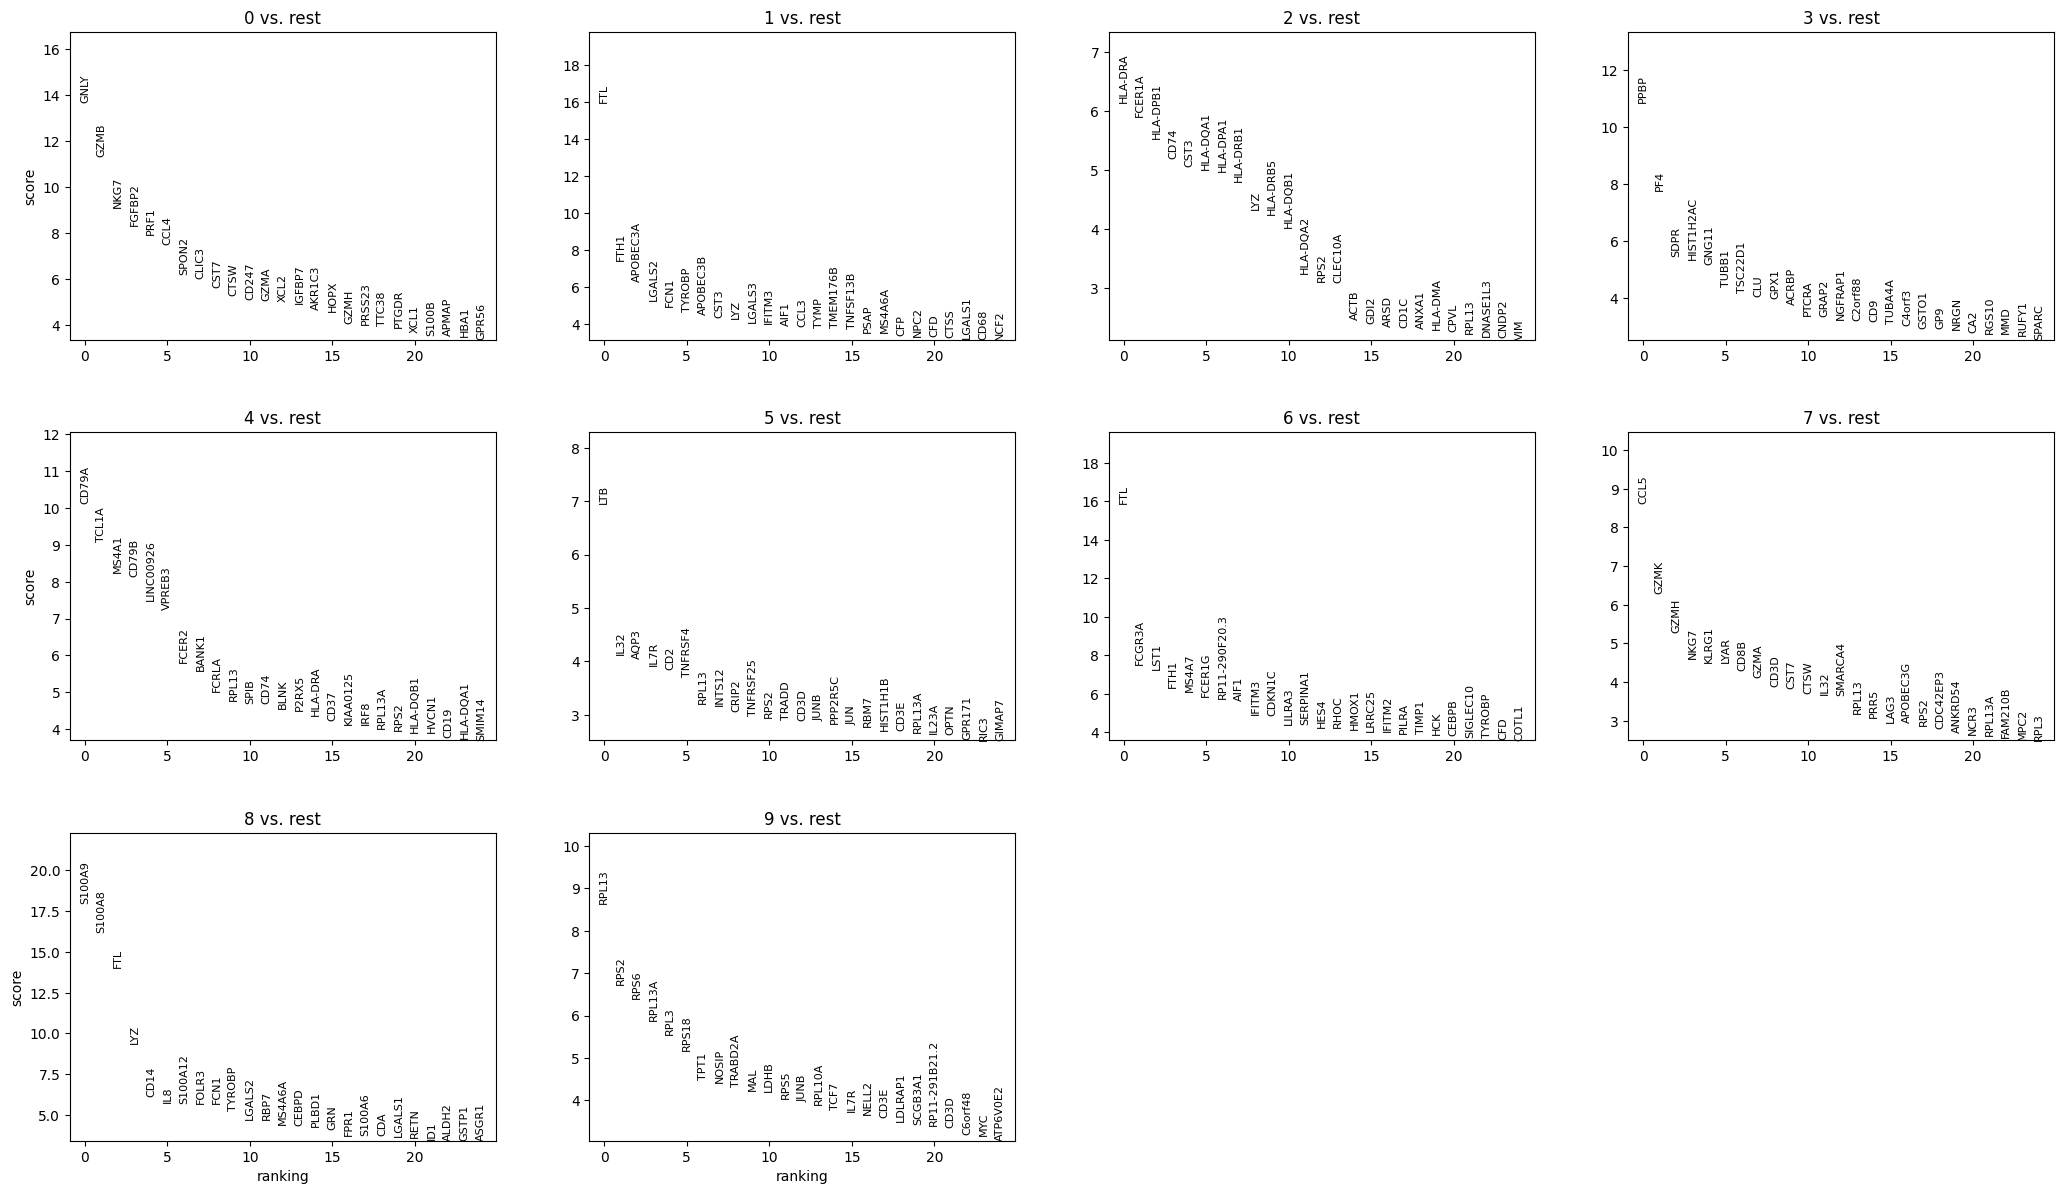

In [25]:
sc.pl.rank_genes_groups(scd.adata, n_genes=25, sharey=False, key="factor_signatures")

Because we have a list of marker genes for each cell type in the data, we can check the association of the learned gene signatures with each cell type's markers.

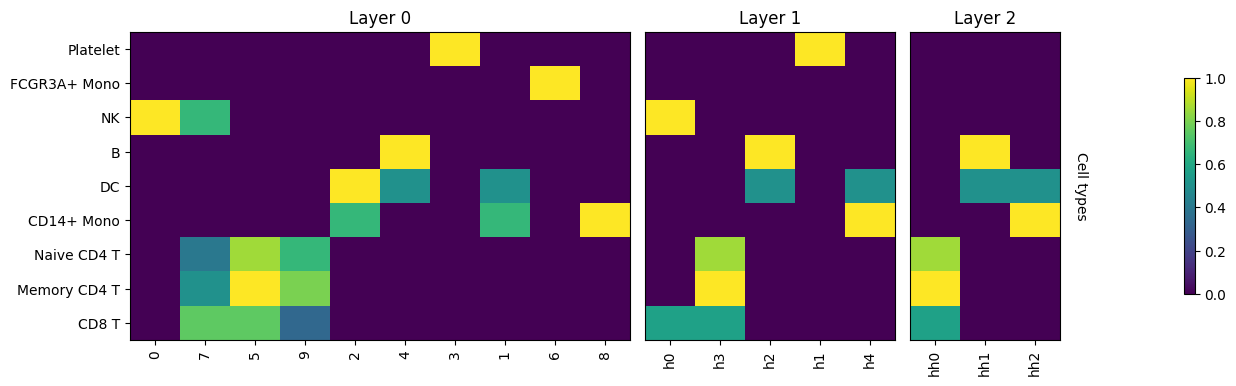

In [26]:
scd.plot_signatures_scores("Cell types", markers, top_genes=20, figsize=(16,4))

#### Visualize PAGA graphs at the different scDEF layers
We can also visualize the multilayer structure of scDEF in a PAGA graph. This will show a graph representing the similarity between the factors at each layer. We can leverage the structure of the scDEF by initializing the graph at each layer `i` with the graph at layer `i+1` to keep them consistent across layers.

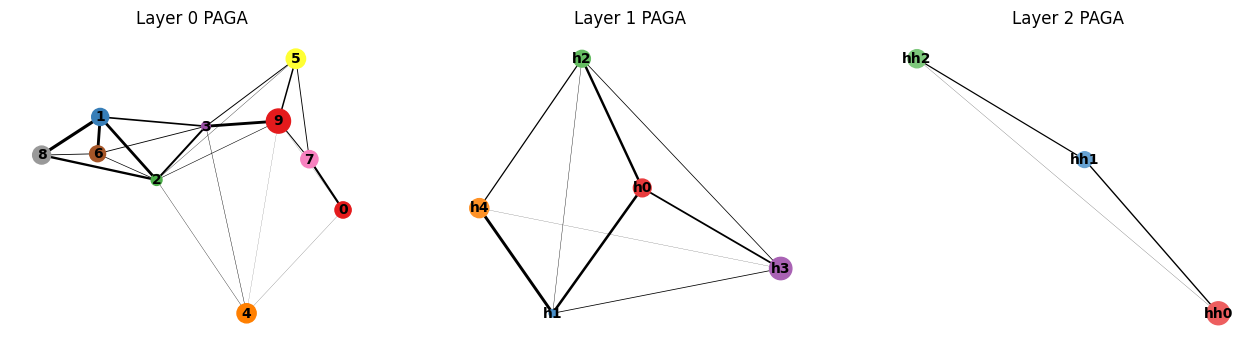

In [27]:
scd.plot_multilevel_paga(figsize=(16,4), reuse_pos=True, frameon=False)

## Informed scDEF
The informed version of scDEF enables the joint assignment of cells to known states given by a dictionary of marker genes, and learning either a lower or higher-resolution description of the data using those states.

Given a list of marker genes for different cell groups, iscDEF can jointly assign cells to those groups and either 1) learn an upper level structure relating the groups or 2) learn a lower level structure containing higher resolution groups of cells within the specified ones.

### Mode 1: learning a higher level structure from cell subtypes
By default, iscDEF will learn put the gene sets as factors in the lowest layer in the hierarchy, which is set to 4 layers, but can be changed with the `n_layers` keyword argument. The factors at the lowest layer will be named after the names in the dictionary that contains the gene sets. In this mode, the BRD prior is deactivated.

In [28]:
iscd = scdef.iscDEF(adata, counts_layer='counts', markers_dict=markers)

print(iscd) # inspect the iscDEF object, which contains a copy of the input AnnData

Did not find gene CCR7 for set Naive CD4 T in AnnData object.


iscDEF object with 5 layers
	Markers layer: 0
	Contains `other` category: False
	Gene set strength: 100.0
	Gene set mean: 10.0
	Layer names: markerfactor, hfactor, hhfactor, hhhfactor, hhhhfactor
	Layer sizes: 9, 5, 3, 2, 1
	Layer shape parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer rate parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer factor shape parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Layer factor rate parameters: 0.3, 0.3, 0.3, 0.3, 1.0
	Number of batches: 1
Contains AnnData object with n_obs × n_vars = 2623 × 4000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell types', 'Coarse cell types'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Coarse cell types_colors', 'Cell types_colors'
    obsm: '

In [29]:
iscd.learn() # learn the hierarchical gene signatures

100%|██████████| 1000/1000 [01:22<00:00, 12.15it/s, Loss=2.88e+6]


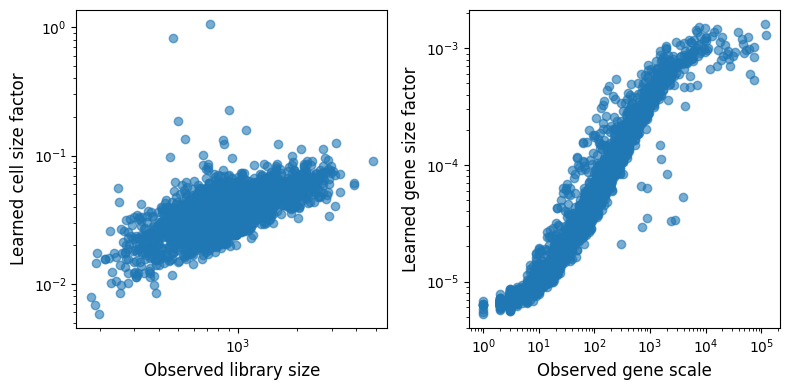

In [30]:
iscd.plot_scales()

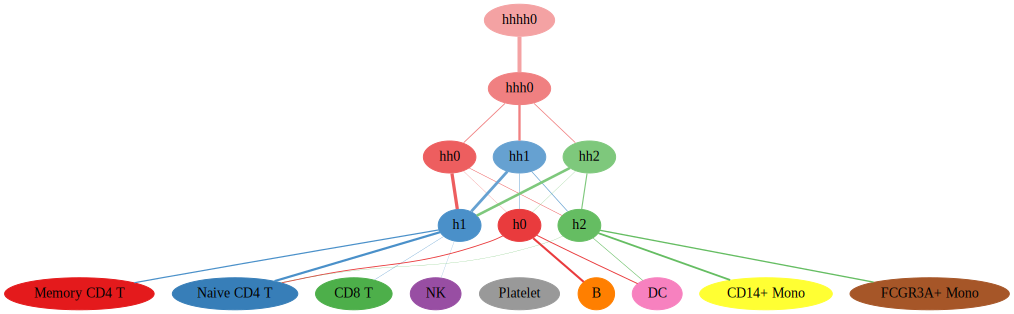

In [31]:
iscd.make_graph(show_signatures=False, filled='factor')
iscd.graph

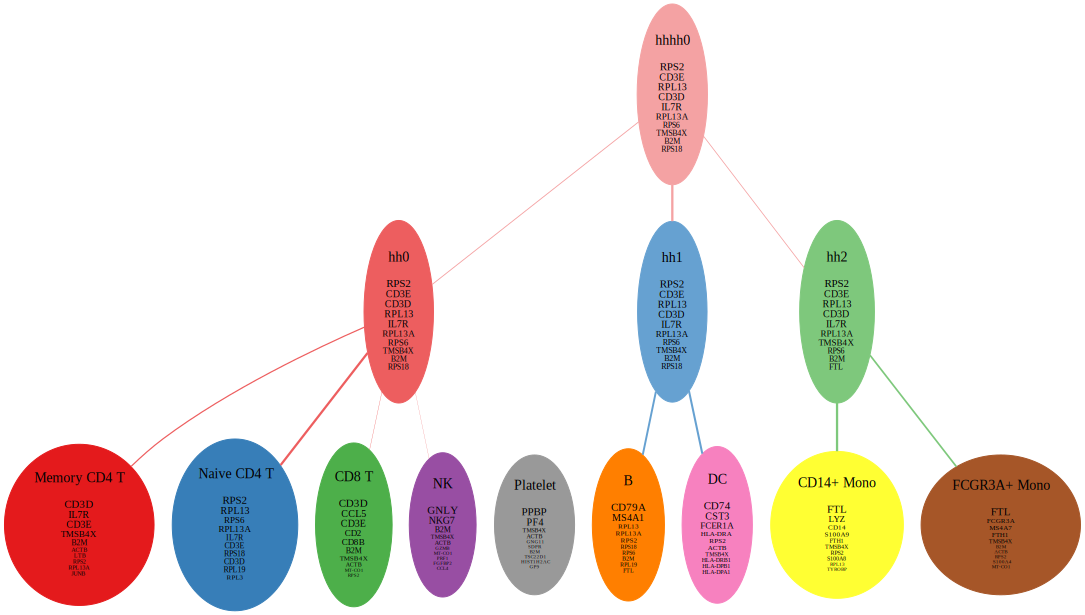

In [32]:
hrc = iscd.get_hierarchy()
iscd.make_graph(hierarchy=hrc, show_signatures=True, filled='factor')
iscd.graph

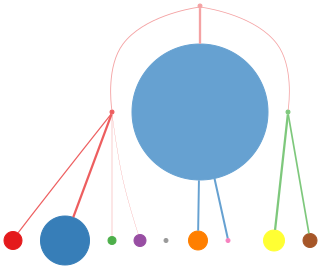

In [33]:
iscd.make_graph(hierarchy=hrc, show_signatures=False, filled='factor', show_label=False, n_cells=True)
iscd.graph

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


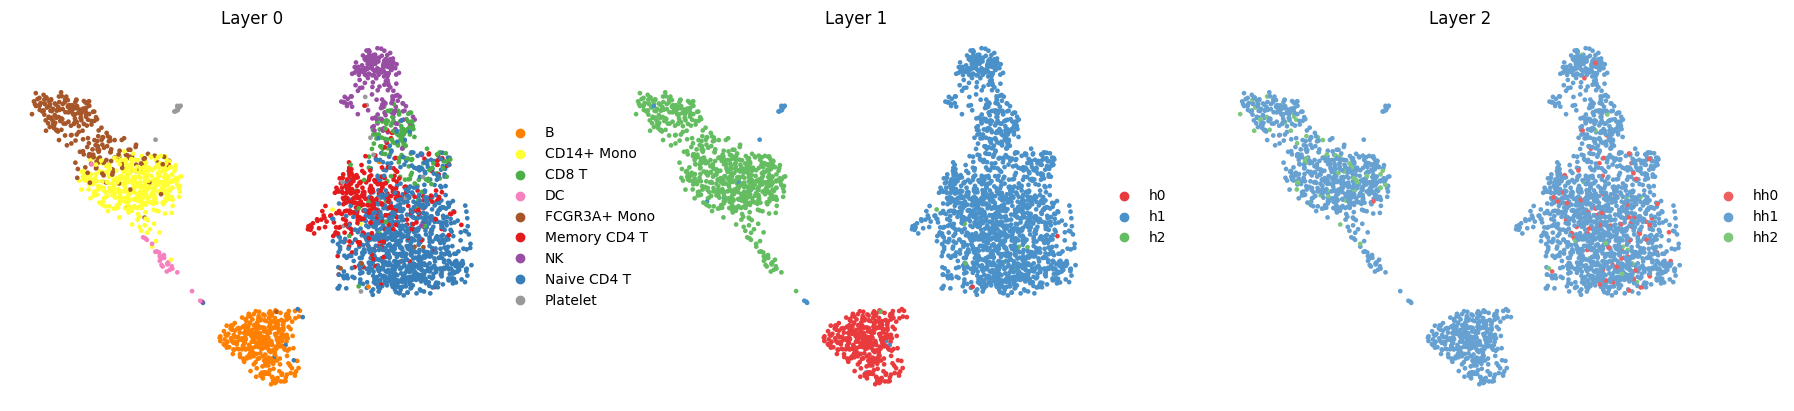

In [34]:
sc.pl.umap(iscd.adata, color=['markerfactor', 'hfactor', 'hhfactor'], 
           title=['Layer 0', 'Layer 1', 'Layer 2'], 
           frameon=False)

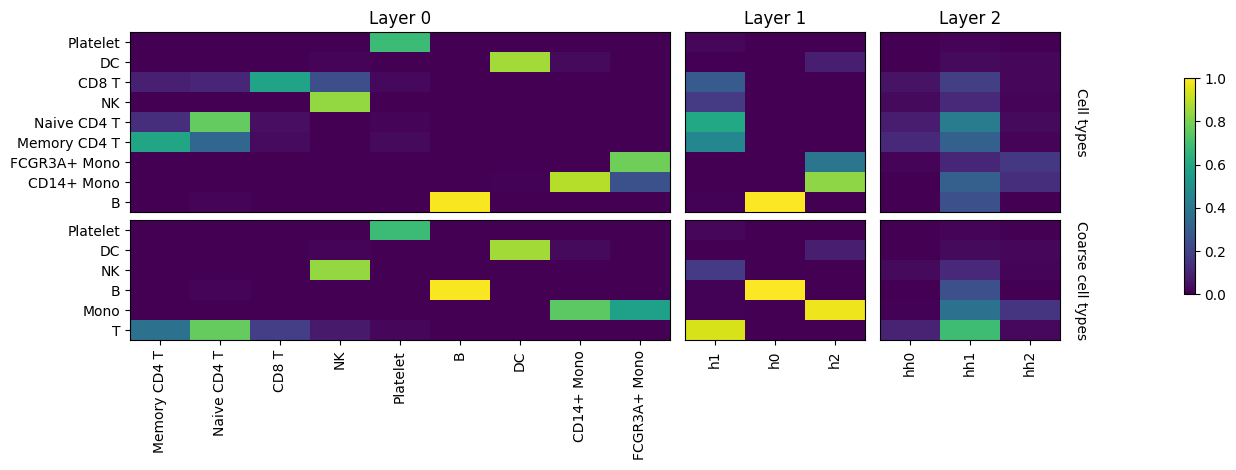

In [35]:
obs_keys = ['Cell types', 'Coarse cell types']
iscd.plot_obs_scores(obs_keys,  figsize=(16,4))

### Mode 2: learning a lower level structure from coarse cell types
If we set markers_layer to a value above 0, iscDEF will put the gene sets in the top level of the hierarchy, whose depth is set to be `markers_layer-1`. Here we set `markers_layer` to 3, which will lead to a 4-level hierarchy (layers are 0-indexed). At each subsequent level, iscDEF will have by default 2 factors per gene-set specific factors. This can be changed with the `n_factors_per_set` keyword argument. This mode will thus be guided by broad gene sets that get refined at each level of the hierarchy. Here we use sets containing markers for T, B and monocytic cells, and learn cell states that correspond to T-, B- and monocyte-specific subpopulations. The BRD prior is by default activated in this mode, and can be used to remove unused factors as in the base scDEF.

In [36]:
top_markers = {'T': ['CD3D', 'CD3E', 'CD8B', 'CD2', 'IL7R', 'NKG7'],
               'Mono': ['LYZ', 'CST3', 'MS4A7'],
               'B': ['MS4A1', 'CD79A']}

iscd = scdef.iscDEF(adata, counts_layer='counts', markers_dict=top_markers, markers_layer=3)
print(iscd) # inspect the iscDEF object, which contains a copy of the input AnnData

iscDEF object with 4 layers
	Markers layer: 3
	Contains `other` category: False
	Gene set strength: 100.0
	Gene set mean: 10.0
	Layer names: factor, hfactor, hhfactor, markerfactor
	Layer sizes: 18, 12, 6, 3
	Layer shape parameters: 0.3, 0.3, 0.3, 0.3
	Layer rate parameters: 0.3, 0.3, 0.3, 0.3
	Connectivity mean: 10.0
	Number of batches: 1
Contains AnnData object with n_obs × n_vars = 2623 × 4000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell types', 'Coarse cell types'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Coarse cell types_colors', 'Cell types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [37]:
iscd.learn() # learn the hierarchical gene signatures

100%|██████████| 1000/1000 [01:27<00:00, 11.43it/s, Loss=2.95e+6]


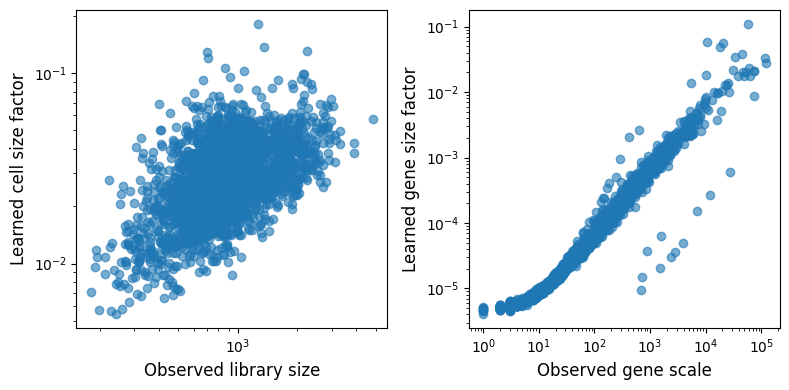

In [38]:
iscd.plot_scales()

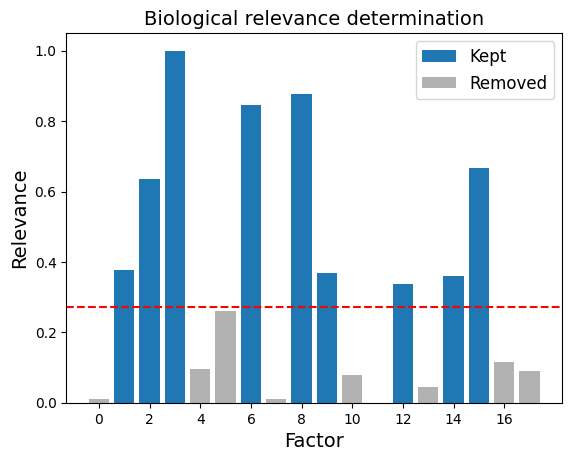

In [39]:
iscd.plot_brd(iqr_mult=1.)

In [40]:
iscd.filter_factors(iqr_mult=1.)

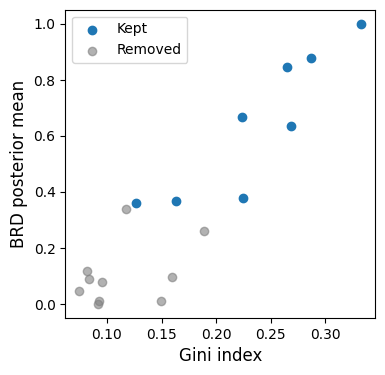

In [41]:
iscd.plot_gini_brd()

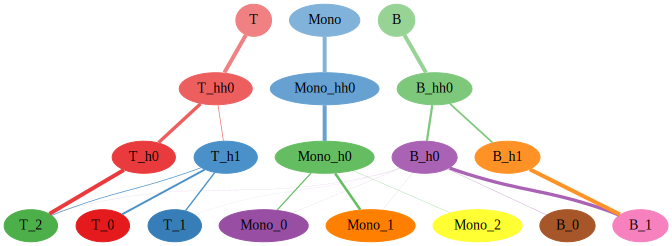

In [42]:
iscd.make_graph(show_signatures=False, filled='factor')
iscd.graph

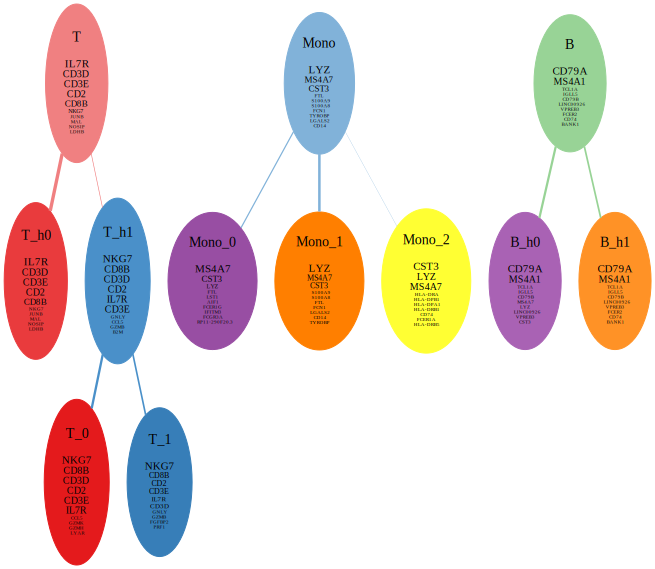

In [43]:
hrc = iscd.get_hierarchy()
iscd.make_graph(hrc, show_signatures=True, filled='factor')
iscd.graph

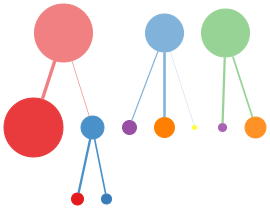

In [44]:
iscd.make_graph(hierarchy=hrc, show_signatures=False, filled='factor', show_label=False, n_cells=True)
iscd.graph

/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cluster/work/bewi/members/pedrof/miniconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


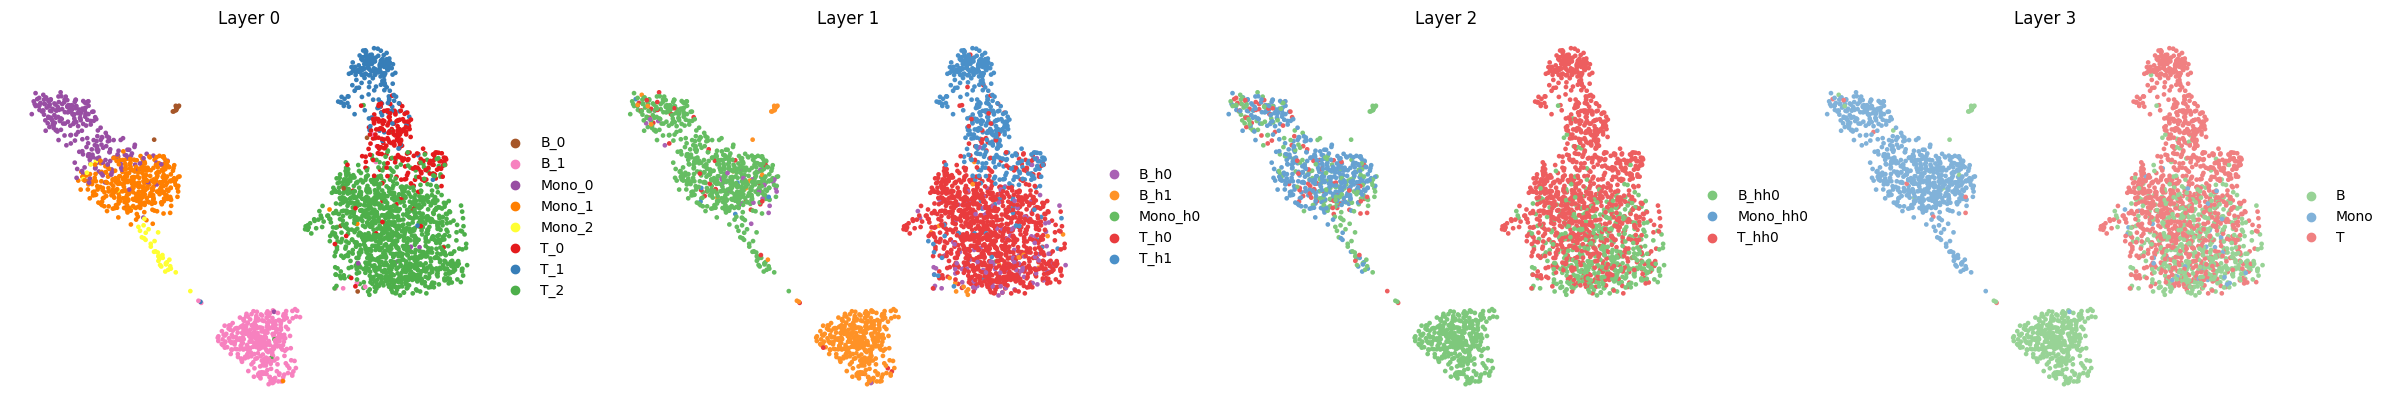

In [45]:
sc.pl.umap(iscd.adata, color=['factor', 'hfactor', 'hhfactor', 'markerfactor'], 
           title=['Layer 0', 'Layer 1', 'Layer 2', 'Layer 3'], frameon=False)

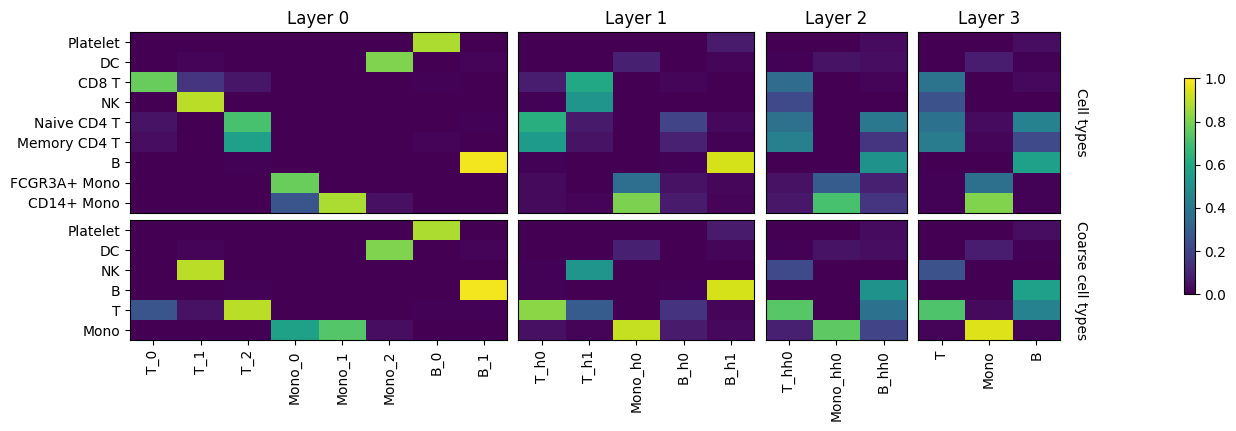

In [46]:
obs_keys = ['Cell types', 'Coarse cell types']
iscd.plot_obs_scores(obs_keys,  figsize=(16,4), sort_layer_factors=False)